## Stock Sentiment Analysis using News Headlines

### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Reading Dataset

#### About the dataset used:
- The data set in consideration is a combination of the world news and stock price shifts.
- Data ranges from 2008 to 2016 and the data from 2000 to 2008 was scrapped from Yahoo finance.
- There are 25 columns of top news headlines for each day in the data frame.
- Class 1- the stock price increased.
- Class 0- the stock price stayed the same or decreased.

In [2]:
df = pd.read_csv('Data.csv', encoding="ISO-8859-1")
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
4,2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,...,Most everywhere: UDIs,Most wanted: Chloe lunettes,Return of the cane 'completely off the agenda',From Sleepy Hollow to Greeneland,Blunkett outlines vision for over 11s,"Embattled Dobson attacks 'play now, pay later'...",Doom and the Dome,What is the north-south divide?,Aitken released from jail,Gone aloft


In [3]:
df.shape

(4101, 27)

### Splitting training and testing dataset

In [4]:
train = df[df['Date']<'20150101']
test = df[df['Date']>'20141231']

### Independent features/ variables

In [5]:
train_data = train.iloc[:,2:27]
# Removing Puncturations from headlines
train_data.replace("[^a-zA-Z0-9]"," ",regex=True, inplace=True)

In [6]:
train_data.head(1)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,A hindrance to operations extracts from the...,Scorecard,Hughes instant hit buoys Blues,Jack gets his skates on at ice cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar s debut double,Southgate strikes Leeds pay the penalty,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl s successor drawn into scandal,The difference between men and women,Sara Denver nurse turned solicitor,Diana s landmine crusade put Tories in a panic,Yeltsin s resignation caught opposition flat f...,Russian roulette,Sold out,Recovering a title


In [7]:
## Cleaning the text
for i in range(train_data.shape[0]):
    for j in range(train_data.shape[1]):
        # Lowering the text
        headline = str(train_data.iloc[i,j]).lower()
        headline = headline.split()
        # Removing stopwords
        headline = [word for word in headline if word not in set(stopwords.words('english'))]
        headline = " ".join(headline)
        train_data.iloc[i,j] = headline

In [8]:
# Joining all 25 headlines
train_transform = []
for row in range(0,len(train_data.index)):
    train_transform.append(" ".join(str(x) for x in train_data.iloc[row,0:25]))

In [9]:
train_transform[0]

'hindrance operations extracts leaked reports scorecard hughes instant hit buoys blues jack gets skates ice cold alex chaos maracana builds united depleted leicester prevail elliott spoils everton party hungry spurs sense rich pickings gunners wide easy target derby raise glass strupar debut double southgate strikes leeds pay penalty hammers hand robson youthful lesson saints party like 1999 wear wolves turned lambs stump mike catches testy gough taunt langer escapes hit 167 flintoff injury piles woe england hunters threaten jospin new battle somme kohl successor drawn scandal difference men women sara denver nurse turned solicitor diana landmine crusade put tories panic yeltsin resignation caught opposition flat footed russian roulette sold recovering title'

### Implementing Bag of Words

In [10]:
# Implementing Bag of Words
cv = CountVectorizer(ngram_range=(1,2))
X_train = cv.fit_transform(train_transform)

### Target variable

In [11]:
y_train = train['Label']

In [12]:
y_train.value_counts()

1    2096
0    1879
Name: Label, dtype: int64

### Training Model

In [13]:
# Implementing Random Forest Classifier
clf = RandomForestClassifier(n_estimators = 200, criterion='entropy')
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

### Test datset

In [14]:
test_data = test.iloc[:,2:27]
test_data.replace("[^a-zA-Z0-9]"," ",regex=True, inplace=True)

for i in range(test_data.shape[0]):
    for j in range(test_data.shape[1]):
        headline = str(test_data.iloc[i,j]).lower()
        headline = headline.split()
        headline = [word for word in headline if word not in set(stopwords.words('english'))]
        headline = " ".join(headline)
        train_data.iloc[i,j] = headline

test_transform = []
for row in range(0,len(test_data.index)):
    test_transform.append(" ".join(str(x) for x in test_data.iloc[row,0:25]))

X_test = cv.transform(test_transform)
y_test = test['Label']

### Prediction for Test dataset

In [15]:
y_pred = clf.predict(X_test)

### Performance of Model

In [16]:
# Accuracy Score
clf.score(X_test, y_test)

0.8544973544973545

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[137,  49],
       [  6, 186]], dtype=int64)

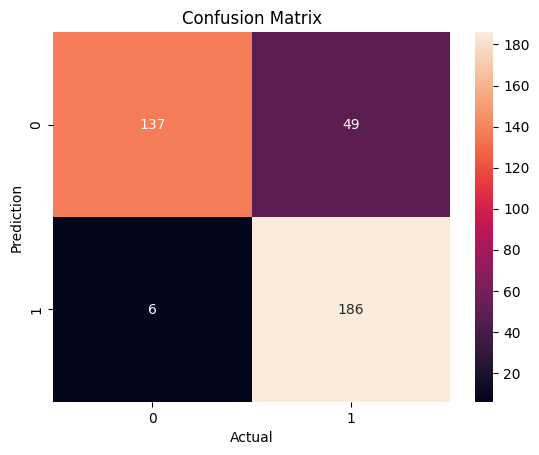

In [18]:
# Heatmap of Confusion Matrix
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83       186
           1       0.79      0.97      0.87       192

    accuracy                           0.85       378
   macro avg       0.87      0.85      0.85       378
weighted avg       0.87      0.85      0.85       378

